In [1]:
import requests

import re

import numpy as np
import pandas as pd

from bs4 import BeautifulSoup

import pprint

from skimage import io, color, filters
from skimage.transform import resize, rotate

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model

# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications import imagenet_utils


import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances

from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model
from keras.preprocessing import image

# from PIL import Image
import pickle
from datetime import datetime
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px

import scipy
import os
import matplotlib
from matplotlib import pyplot as plt

import itertools

import shutil
import random
import glob


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# from PIL import Image
from IPython.display import display, Image


matplotlib.style.use('ggplot')
%matplotlib inline


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1*X GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=(1024*4))])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
mens = pd.read_csv('mens.csv', index_col=0)

In [4]:
tfidf = TfidfVectorizer(lowercase=True, tokenizer=None,
                             analyzer='word', max_features=1000)

document_tfidf_matrix = tfidf.fit_transform(mens['tags'])

tfidf_df = pd.DataFrame(document_tfidf_matrix.todense(), columns = sorted(tfidf.vocabulary_))
tfidf_df

,10,100,10d,10m,11,12,13,13m,14,15,...,yeezy,yellow,yes,york,zegna,zerogrand,zip,zipped,zipper,zoom
0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00000,0.0,0.0,0.0,0.0,0.288507,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.24218,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10537,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10538,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10539,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10540,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
reconstructed_model = keras.models.load_model('./flask/retrainresnet')

reconstructed_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [6]:
new_model = Model(reconstructed_model.inputs, reconstructed_model.layers[-2].output)

new_model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [7]:
extracted_features = np.load('./imgs/resnet_features.npy')
Productids = np.load('./imgs/resnet_feature_product_ids.npy')

df_Productids = list(mens['ProductId'])
Productids = list(Productids)

In [8]:
def preproc(img_path, model):
    return ImageDataGenerator(rescale= 1. / 255, preprocessing_function=tf.keras.applications.resnet.preprocess_input) \
    .flow_from_directory(directory=img_path, target_size=(224,224), batch_size=1)[0][0]

In [23]:
transformed = preproc('../../../Desktop/holdout', new_model)

Found 1 images belonging to 1 classes.


In [24]:
test_feats = new_model.predict(transformed, verbose=1, batch_size=1)

1/1 [==============================] - 0s 632us/step


In [141]:
def get_similar_new(img_path, feats, num_results, words=None):
    
    pairwise_dist = pairwise_distances(extracted_features, feats.reshape(1,-1))
    
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    
    if words:
        
        tfidf = TfidfVectorizer(lowercase=True, tokenizer=None,
                             analyzer='word', max_features=1000)
        
        queryTFIDF = tfidf.fit(mens['tags'])
        queryTFIDF = queryTFIDF.transform([words])
        
        cosine_similarities = cosine_similarity(queryTFIDF, document_tfidf_matrix).flatten()
        
        indices = cosine_similarities.argsort()[:-(num_results + 20):-1]
    
        pairwise_dist = pairwise_distances(extracted_features[indices], feats.reshape(1,-1))   
                                                              
    display(Image(img_path, width = 224, height = 224,embed=True))
    
    print(indices)

    print("Recommended products")

    res = mens[['image_link','title', 'price']].loc[indices]
    
    for indx, row in res.iterrows():
        display(Image(url=row['image_link'], width = 224, height = 224,embed=True))
        print('Product Title: ', row['title'])
            
    return '$' + str(np.round(np.mean(res.price), 2))

In [ ]:
display(Image('../../../Desktop/holdout/holdout/sneakers.jpg', width = 224, height = 224,embed=True))

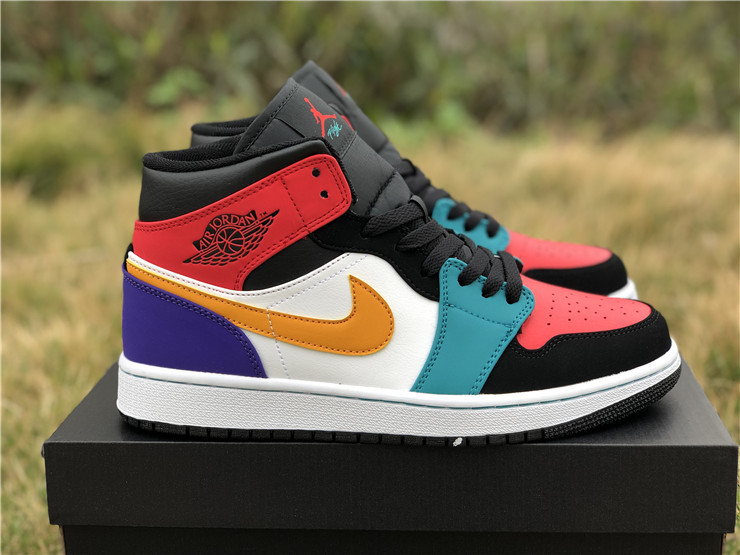

[7724 7885 7762 7772 7650]
Recommended products


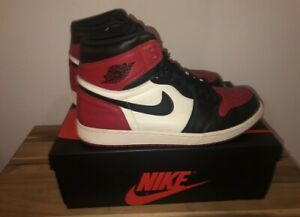

Product Title:  Nike Air Jordan 1 Retro High OG Bred Toe Men’s Size 12


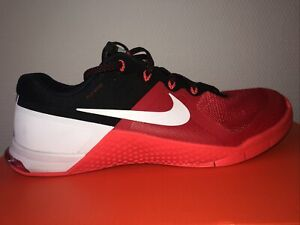

Product Title:  Nike Metcon 2 size 10 (university Red) 


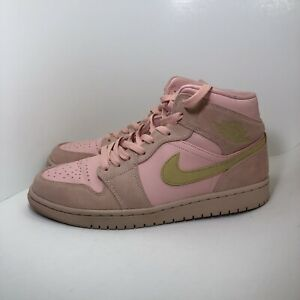

Product Title:  Jordan 1 Coral Gold Sz 10.5


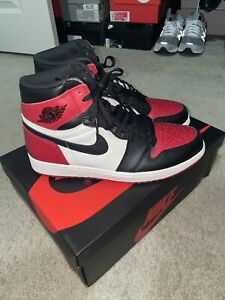

Product Title:  Nike Air Jordan Retro 1 High Bred Toe 100%Authentic


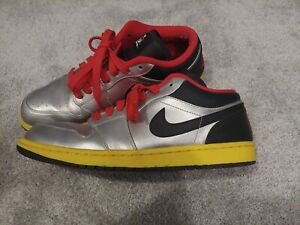

Product Title:  Nike Air Jordan 1 low  Johnny Kilroy Men's shoes 11.5 metallic silver red yellow


'$259.79'

In [143]:
get_similar_new('../../../Desktop/holdout/holdout/sneakers.jpg', test_feats, 5)